In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.8 MB/s eta 0:00:0000:01


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import snntorch as snn
from snntorch import spikegen
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pip install snntorch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 1

Using device: cuda
IMPROVED SETTINGS:
  Training batches per epoch: 20
  Train feature batches: 50
  Epochs: 10
Loading dataset...
Total samples: 41091
IMPROVED: Fast training + Full test evaluation
Expected accuracy improvement: 74% -> 76-80%
Epoch 1/10
  Processed 20 batches
Epoch 2/10
Epoch 3/10
Epoch 4/10
  Processed 20 batches
Epoch 5/10
Epoch 6/10
Epoch 7/10
  Processed 20 batches
Epoch 8/10
Epoch 9/10
Epoch 10/10
  Processed 20 batches


Extracting TEST features (FULL dataset): 100%|██████████| 140/140 [18:44<00:00,  8.03s/it]


Train features: torch.Size([3200, 8448])
Test features: torch.Size([8926, 8448])


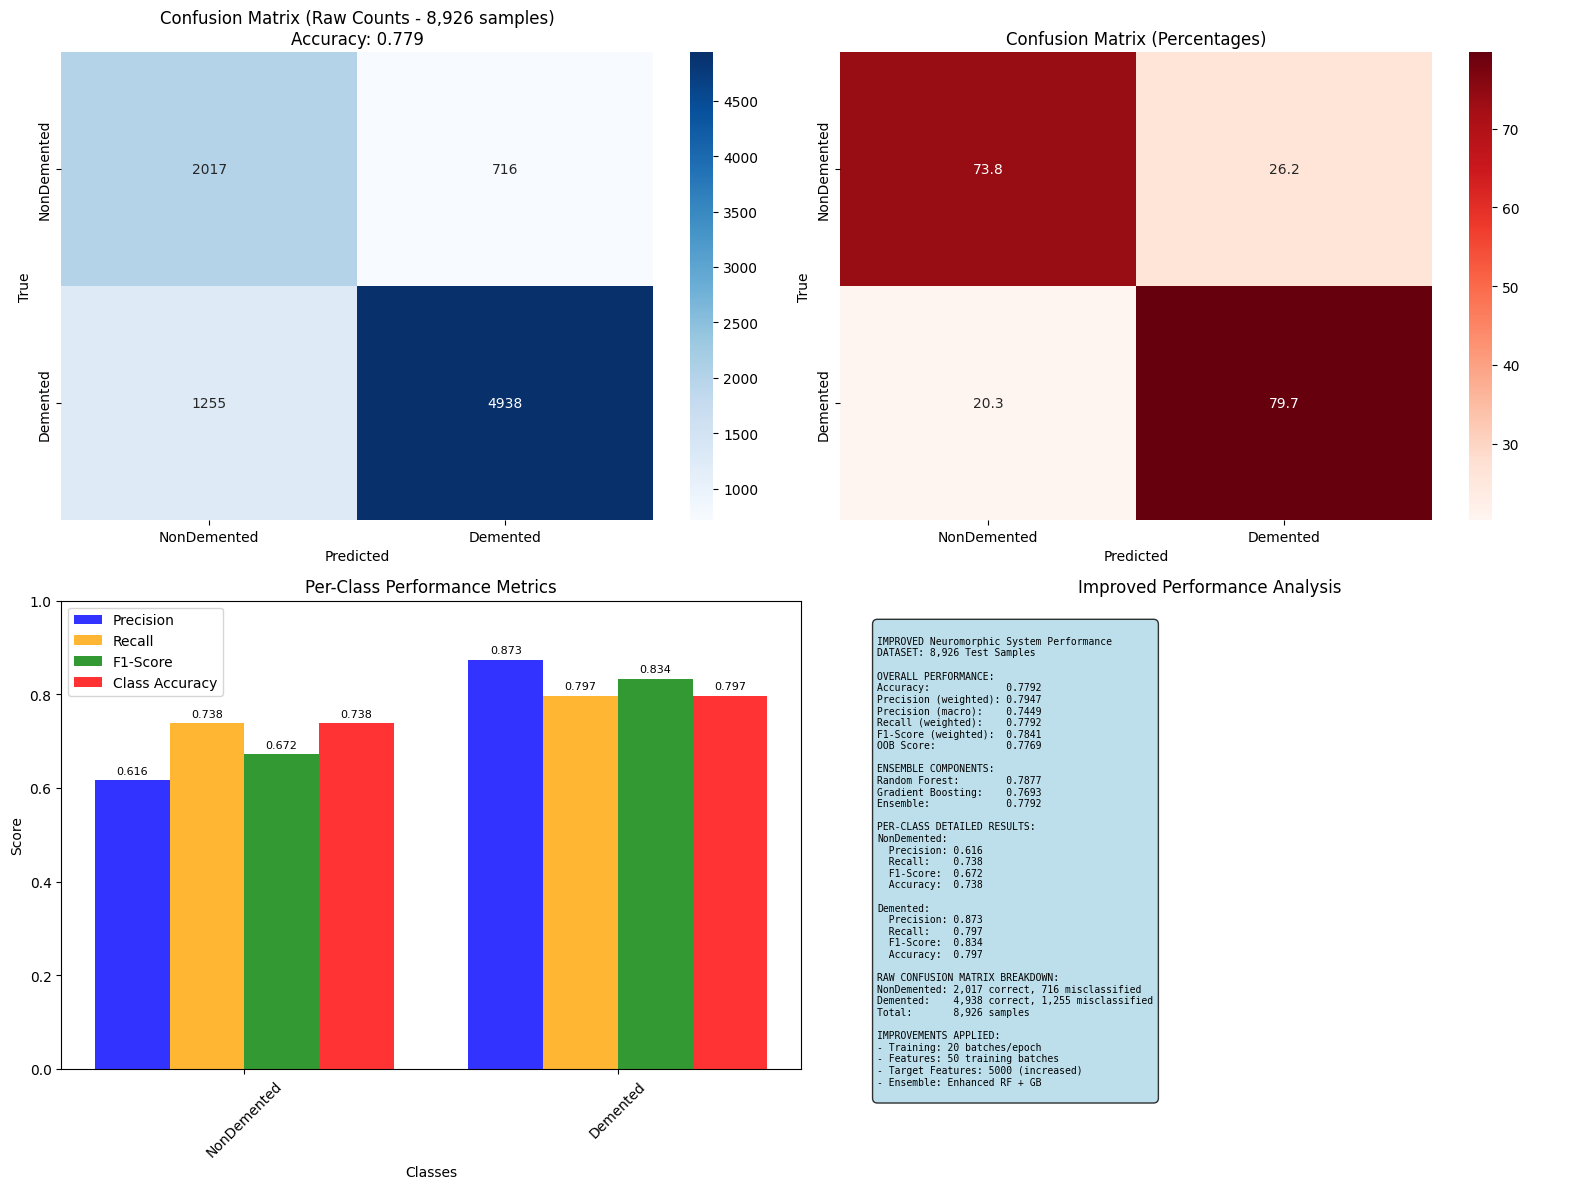

Accuracy: 0.7792 
Total test samples: 8,926
F1-Score: 0.7841
OOB Score: 0.7769


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, f1_score, 
                           precision_score, recall_score, accuracy_score)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import snntorch as snn
import cv2
from scipy import ndimage
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters 
TIME_STEPS = 20
BATCH_SIZE = 64
EPOCHS = 10  
IMG_SIZE = 32
INPUT_SIZE = IMG_SIZE * IMG_SIZE


FAST_TRAINING_BATCHES = 20  
FAST_TRAIN_FEATURES = 50    

print(f"IMPROVED SETTINGS:")
print(f"  Training batches per epoch: {FAST_TRAINING_BATCHES}")
print(f"  Train feature batches: {FAST_TRAIN_FEATURES}")
print(f"  Epochs: {EPOCHS}")

# Load Alzheimer's dataset
print("Loading dataset...")
images = []
labels = []

def load_datasets(original_path, additional_path=None):
    images = []
    labels = []
    
    for subfolder in os.listdir(original_path):
        subfolder_path = os.path.join(original_path, subfolder)
        for folder in os.listdir(subfolder_path):
            subfolder_path2 = os.path.join(subfolder_path, folder)
            for image_filename in os.listdir(subfolder_path2):
                if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    image_path = os.path.join(subfolder_path2, image_filename)
                    images.append(image_path)
                    labels.append(folder)
    
    if additional_path and os.path.exists(additional_path):
        for class_folder in ['Demented', 'NonDemented']:
            class_path = os.path.join(additional_path, class_folder)
            if os.path.exists(class_path):
                items = os.listdir(class_path)
                for item in items:
                    item_path = os.path.join(class_path, item)
                    if os.path.isdir(item_path):
                        for image_file in os.listdir(item_path):
                            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                                image_path = os.path.join(item_path, image_file)
                                images.append(image_path)
                                labels.append(class_folder)
                    elif item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        images.append(item_path)
                        labels.append(class_folder)
    
    return images, labels

BASE_PATH = '/kaggle/input/alzheimerdataset'
ADDITIONAL_PATH = '/kaggle/input/nins-dementia-v2'

images, labels = load_datasets(BASE_PATH, ADDITIONAL_PATH)

df = pd.DataFrame({'image': images, 'label': labels})

def create_binary_labels(label):
    if label == "NonDemented":
        return 0
    else:
        return 1

df['label_idx'] = df['label'].apply(create_binary_labels)
label_to_idx = {'NonDemented' : 0, 'Demented' : 1}

print(f"Total samples: {len(df)}")

class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label_idx']
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

class NeuromorphicSingleEncodingPreprocessor:
    def __init__(self, time_steps=20, img_size=32):
        self.time_steps = time_steps
        self.img_size = img_size
        
    def skull_strip_brain_scan(self, image_tensor):
        device = image_tensor.device
        batch_size = image_tensor.shape[0]
        processed_images = []
        
        for i in range(batch_size):
            img = image_tensor[i].cpu().numpy().reshape(self.img_size, self.img_size)
            img_8bit = (img * 255).astype(np.uint8)
            
            blurred = cv2.GaussianBlur(img_8bit, (5, 5), 0)
            _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
            
            contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                mask = np.zeros_like(img_8bit)
                cv2.drawContours(mask, [largest_contour], -1, 255, -1)
                skull_stripped = cv2.bitwise_and(img_8bit, mask)
            else:
                skull_stripped = img_8bit
            
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
            enhanced = clahe.apply(skull_stripped)
            
            processed_img = torch.from_numpy(enhanced / 255.0).float().to(device)
            processed_images.append(processed_img.flatten())
        
        return torch.stack(processed_images, dim=0)
    
    def neuromorphic_temporal_encoding(self, data):
        device = data.device
        batch_size, features = data.shape
        
        data_norm = torch.clamp(data, 0, 1)
        spikes = torch.zeros(self.time_steps, batch_size, features, device=device)
        
        for b in range(batch_size):
            for f in range(features):
                intensity = data_norm[b, f].item()
                if intensity > 0.1:
                    spike_time = int((1 - intensity) * (self.time_steps - 1))
                    spike_time = max(0, min(spike_time, self.time_steps - 1))
                    spikes[spike_time, b, f] = 1.0
                    
                    if intensity > 0.8 and spike_time + 1 < self.time_steps:
                        spikes[spike_time + 1, b, f] = 0.5
        
        return spikes
    
    def extract_neuromorphic_features(self, spikes):
        features = []
        
        features.append(spikes.mean(dim=0))
        features.append(spikes.sum(dim=0))
        features.append(spikes.std(dim=0))
        features.append(spikes.max(dim=0)[0])
        
        batch_size, pixel_features = spikes.shape[1], spikes.shape[2]
        
        first_spike = torch.zeros(batch_size, pixel_features, device=spikes.device)
        for b in range(batch_size):
            for f in range(pixel_features):
                spike_times = torch.nonzero(spikes[:, b, f])
                if len(spike_times) > 0:
                    first_spike[b, f] = spike_times[0].float() / self.time_steps
                else:
                    first_spike[b, f] = 1.0
        features.append(first_spike)
        
        burst_features = torch.zeros_like(spikes[0])
        for t in range(1, self.time_steps):
            consecutive_spikes = spikes[t-1] * spikes[t]
            burst_features += consecutive_spikes
        features.append(burst_features)
        
        phase1 = spikes[:self.time_steps//2].mean(dim=0)
        phase2 = spikes[self.time_steps//2:].mean(dim=0)
        features.extend([phase1, phase2])
        
        return torch.cat(features, dim=1)
    
    def __call__(self, batch_data, add_noise=False):
        device = batch_data.device
        
        skull_stripped = self.skull_strip_brain_scan(batch_data)
        temporal_spikes = self.neuromorphic_temporal_encoding(skull_stripped)
        temporal_features = self.extract_neuromorphic_features(temporal_spikes)
        
        combined_features = temporal_features
        combined_features = torch.nan_to_num(combined_features, 0.0)
        combined_features = torch.clamp(combined_features, -10, 10)
        
        if add_noise:
            noise = torch.randn_like(combined_features) * 0.02
            noisy_features = combined_features + noise
            return noisy_features, combined_features
        
        return combined_features, combined_features

class ForwardForwardRSTDPAutoencoder(nn.Module):
    
    def __init__(self, input_size, time_steps, latent_dim=256):
        super(ForwardForwardRSTDPAutoencoder, self).__init__()
        self.input_size = input_size
        self.time_steps = time_steps
        self.latent_dim = latent_dim
        
        self.encoder1 = nn.Linear(input_size, 512, bias=True)     
        self.encoder2 = nn.Linear(512, 256, bias=True)           
        self.bottleneck = nn.Linear(256, self.latent_dim, bias=True)  
        self.decoder1 = nn.Linear(self.latent_dim, 256, bias=True)
        self.decoder2 = nn.Linear(256, 512, bias=True)
        self.decoder3 = nn.Linear(512, input_size, bias=True)
        
        self.threshold = 1.5
        self.ff_learning_rate = 0.01
        
        self.tau_pre = 20.0
        self.tau_post = 20.0
        self.A_plus = 0.02
        self.A_minus = 0.01
        
        self.reward_baseline = 0.0
        self.reward_lr = 0.2
        self.layer_norms = [0.3, 0.25, 0.2]
        
        self.init_weights_aggressive()
    
    def init_weights_aggressive(self):
        for i, layer in enumerate([self.encoder1, self.encoder2, self.bottleneck]):
            nn.init.normal_(layer.weight, mean=0.0, std=self.layer_norms[i])
            if layer.bias is not None:
                nn.init.normal_(layer.bias, mean=0.0, std=0.1)
        for layer in [self.decoder1, self.decoder2, self.decoder3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.2)
            if layer.bias is not None:
                nn.init.normal_(layer.bias, mean=0.0, std=0.1)
    
    def encode_to_z_m(self, input_features):
        with torch.no_grad():
            x1 = torch.relu(self.encoder1(input_features))
            x2 = torch.relu(self.encoder2(x1))
            z_m_raw = self.bottleneck(x2)
            z_m = torch.sigmoid(z_m_raw)
            return z_m.detach()
    
    def decode_from_z_m(self, z_m):
        with torch.no_grad():
            x = torch.relu(self.decoder1(z_m))
            x = torch.relu(self.decoder2(x))
            reconstruction = self.decoder3(x)
            return reconstruction
    
    def get_z_m_batch(self, dataloader, preprocessor, max_batches=None):
        z_m_vectors = []
        labels_list = []
        
        self.eval()
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(tqdm(dataloader, desc="Extracting z_m")):
                if max_batches is not None and batch_idx >= max_batches:
                    break
                    
                data = data.to(device)
                combined_features, _ = preprocessor(data)
                combined_features = combined_features.to(device)
                
                z_m = self.encode_to_z_m(combined_features)
                z_m_vectors.append(z_m.cpu())
                labels_list.append(labels)
        
        return torch.cat(z_m_vectors, dim=0), torch.cat(labels_list, dim=0)
    
    def forward(self, input_features):
        x1 = torch.relu(self.encoder1(input_features))
        x2 = torch.relu(self.encoder2(x1))
        z_m_raw = self.bottleneck(x2)
        z_m = torch.sigmoid(z_m_raw)
        
        d1 = torch.relu(self.decoder1(z_m))
        d2 = torch.relu(self.decoder2(d1))
        reconstruction = self.decoder3(d2)
        
        return reconstruction, z_m
    
    def create_positive_negative_samples(self, x, noise_level=0.2):
        batch_size = x.shape[0]
        positive_samples = x.clone()
        negative_samples = x.clone()
        
        noise = torch.randn_like(x) * noise_level * 2.0
        negative_samples += noise
        
        for i in range(batch_size):
            n_shuffle = int(0.4 * x.shape[1])
            shuffle_idx = torch.randperm(x.shape[1])[:n_shuffle]
            random_sample_idx = torch.randint(0, batch_size, (1,)).item()
            negative_samples[i, shuffle_idx] = x[random_sample_idx, shuffle_idx]
        
        invert_mask = torch.rand_like(x) < 0.2
        negative_samples[invert_mask] = 1.0 - negative_samples[invert_mask]
        
        random_mask = torch.rand_like(x) < 0.1
        negative_samples[random_mask] = torch.rand_like(negative_samples[random_mask])
        
        combined_samples = torch.cat([positive_samples, negative_samples], dim=0)
        labels = torch.cat([torch.ones(batch_size), torch.zeros(batch_size)], dim=0)
        
        return combined_samples, labels
    
    def direct_weight_updates(self, features):
        with torch.no_grad():
            x1 = torch.relu(self.encoder1(features))
            if x1.sum() < 1e-6:
                self.encoder1.weight.data += torch.randn_like(self.encoder1.weight) * 0.1
                self.encoder1.bias.data += torch.randn_like(self.encoder1.bias) * 0.1
            
            x2 = torch.relu(self.encoder2(x1))
            if x2.sum() < 1e-6:
                self.encoder2.weight.data += torch.randn_like(self.encoder2.weight) * 0.1
                self.encoder2.bias.data += torch.randn_like(self.encoder2.bias) * 0.1

            z_raw = self.bottleneck(x2)
            if z_raw.std() < 1e-6:
                self.bottleneck.weight.data += torch.randn_like(self.bottleneck.weight) * 0.15
                self.bottleneck.bias.data += torch.randn_like(self.bottleneck.bias) * 0.15
    
    def aggressive_ff_update(self, layer, x_pos, x_neg, layer_idx):
        with torch.no_grad():
            h_pos = layer(x_pos)
            h_neg = layer(x_neg)
            
            if layer_idx < 2:
                h_pos_act = torch.relu(h_pos)
                h_neg_act = torch.relu(h_neg)
            else:
                h_pos_act = torch.sigmoid(h_pos)
                h_neg_act = torch.sigmoid(h_neg)
            
            goodness_pos = torch.sum(h_pos_act ** 2, dim=1)
            goodness_neg = torch.sum(h_neg_act ** 2, dim=1)
            
            pos_loss = torch.relu(self.threshold - goodness_pos) * 2.0
            neg_loss = torch.relu(goodness_neg - self.threshold) * 2.0

            total_grad = torch.zeros_like(layer.weight)
            bias_grad = torch.zeros_like(layer.bias)
            
            for i in range(len(x_pos)):
                if pos_loss[i] > 0:
                    grad = torch.outer(h_pos_act[i], x_pos[i]) * pos_loss[i].item()
                    total_grad += grad * 3.0
                    bias_grad += h_pos_act[i] * pos_loss[i].item() * 3.0
            
            for i in range(len(x_neg)):
                if neg_loss[i] > 0:
                    grad = torch.outer(h_neg_act[i], x_neg[i]) * neg_loss[i].item()
                    total_grad -= grad * 3.0
                    bias_grad -= h_neg_act[i] * neg_loss[i].item() * 3.0

            layer.weight.data += self.ff_learning_rate * (total_grad / (len(x_pos) + len(x_neg)))
            layer.bias.data += self.ff_learning_rate * (bias_grad / (len(x_pos) + len(x_neg)))
            
            layer.weight.data = torch.clamp(layer.weight.data, -0.5, 0.5)
            layer.bias.data = torch.clamp(layer.bias.data, -0.3, 0.3)
            
            return goodness_pos.mean(), goodness_neg.mean()
    
    def emergency_weight_boost(self):
        with torch.no_grad():
            self.encoder1.weight.data *= 1.5
            self.encoder1.bias.data += torch.randn_like(self.encoder1.bias) * 0.2
            
            self.encoder2.weight.data *= 1.5
            self.encoder2.bias.data += torch.randn_like(self.encoder2.bias) * 0.2
            
            self.bottleneck.weight.data *= 2.0
            self.bottleneck.bias.data += torch.randn_like(self.bottleneck.bias) * 0.3
    
   
    def train_ff_rstdp_neuromorphic(self, data_loader, preprocessor, epochs=12):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            batch_count = 0
            for batch_idx, (data, labels) in enumerate(data_loader):
                if batch_idx >= FAST_TRAINING_BATCHES:  
                    break
                
                data = data.to(device)
                features, _ = preprocessor(data)
                features = features.to(device)
                
                
                if batch_idx < 5:
                    self.direct_weight_updates(features)
                
                combined_samples, sample_labels = self.create_positive_negative_samples(features)
                pos_samples = combined_samples[sample_labels == 1]
                neg_samples = combined_samples[sample_labels == 0]
                
                current_pos = pos_samples
                current_neg = neg_samples
                
                layers = [self.encoder1, self.encoder2, self.bottleneck]
                layer_goodness_pos = []
                layer_goodness_neg = []
                
                for layer_idx, layer in enumerate(layers):
                    goodness_pos, goodness_neg = self.aggressive_ff_update(
                        layer, current_pos, current_neg, layer_idx
                    )
                    
                    layer_goodness_pos.append(goodness_pos)
                    layer_goodness_neg.append(goodness_neg)
                    
                    with torch.no_grad():
                        if layer_idx < len(layers) - 1:
                            current_pos = torch.relu(layer(current_pos))
                            current_neg = torch.relu(layer(current_neg))
                        else:
                            current_pos = torch.sigmoid(layer(current_pos))
                            current_neg = torch.sigmoid(layer(current_neg))
                
                with torch.no_grad():
                    test_z_m = self.encode_to_z_m(pos_samples[:4])
                    z_m_std = test_z_m.std().item()
                    
                    if z_m_std < 1e-6:
                        self.emergency_weight_boost()
                
                batch_count += 1
            
            if epoch % 3 == 0:  # Print every 3 epochs
                print(f"  Processed {batch_count} batches")

def extract_neuromorphic_features_smart(autoencoder, dataloader, preprocessor, max_batches=None, dataset_type="unknown"):
    all_features = []
    all_labels = []
    
    desc = f"Extracting {dataset_type} features"
    if max_batches:
        desc += f" ({max_batches} batches)"
    else:
        desc += " (FULL dataset)"
    
    autoencoder.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(tqdm(dataloader, desc=desc)):
            if max_batches is not None and batch_idx >= max_batches:
                break
            
            data = data.to(device)
            combined_features, _ = preprocessor(data)
            combined_features = combined_features.to(device)
            
            reconstruction, bottleneck_features = autoencoder(combined_features)
            
            final_features = torch.cat([combined_features, bottleneck_features], dim=1)
            
            all_features.append(final_features.cpu())
            all_labels.append(labels)
    
    features_tensor = torch.cat(all_features, dim=0)
    labels_tensor = torch.cat(all_labels, dim=0)
    
    return features_tensor, labels_tensor


def advanced_feature_selection(train_features, train_labels, test_features, target_features=3000):  

    print(f"Original features: {train_features.shape[1]}")
    X_train = train_features.numpy()
    X_test = test_features.numpy()
    y_train = train_labels.numpy()
    
    X_train = np.nan_to_num(X_train, 0.0)
    X_test = np.nan_to_num(X_test, 0.0)
    
    # Looser variance filtering
    variance_selector = VarianceThreshold(threshold=0.005)  
    X_train_var = variance_selector.fit_transform(X_train)
    X_test_var = variance_selector.transform(X_test)
    
    # Keep more features in statistical selection
    k_best = min(target_features * 3, X_train_var.shape[1])  
    stat_selector = SelectKBest(score_func=f_classif, k=k_best)
    X_train_stat = stat_selector.fit_transform(X_train_var, y_train)
    X_test_stat = stat_selector.transform(X_test_var)
    
    # RFE with more features
    rf_selector = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1) 
    rfe_selector = RFE(estimator=rf_selector, n_features_to_select=target_features, step=300)  
    X_train_final = rfe_selector.fit_transform(X_train_stat, y_train)
    X_test_final = rfe_selector.transform(X_test_stat)
    print(f"After RFE: {X_train_final.shape[1]}")
    
    return (X_train_final, X_test_final, 
            {'variance': variance_selector, 'statistical': stat_selector, 'rfe': rfe_selector})


def train_fast_ensemble_classifier(X_train, y_train, X_test, y_test):
    X_train = np.nan_to_num(X_train, 0.0)
    X_test = np.nan_to_num(X_test, 0.0)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    rf = RandomForestClassifier(
        n_estimators=600,      
        max_depth=25,          
        min_samples_split=2,   
        min_samples_leaf=1,    
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        oob_score=True,
        n_jobs=-1
    )
    rf.fit(X_train_scaled, y_train)
    rf_oob_score = rf.oob_score_
    
    
    gb = GradientBoostingClassifier(
        n_estimators=150,      
        max_depth=6,          
        learning_rate=0.1,     
        subsample=0.85,        
        random_state=42,
        validation_fraction=0.15,  
        n_iter_no_change=12    
    )
    gb.fit(X_train_scaled, y_train)
    
    ensemble = VotingClassifier([
        ('rf', rf),
        ('gb', gb)
    ], voting='soft')
    ensemble.fit(X_train_scaled, y_train)
    
    y_pred = ensemble.predict(X_test_scaled)
    y_pred_proba = ensemble.predict_proba(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    rf_pred = rf.predict(X_test_scaled)
    gb_pred = gb.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    gb_accuracy = accuracy_score(y_test, gb_pred)
    
    return ensemble, scaler, {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'precision_macro': precision_macro,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'oob_score': rf_oob_score,
        'rf_accuracy': rf_accuracy,
        'gb_accuracy': gb_accuracy
    }


def generate_comprehensive_confusion_matrix(y_true, y_pred, class_names, results, save_path=None):
    
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Calculate per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    accuracy_per_class = []
    
    # Calculate accuracy per class
    for i in range(len(class_names)):
        true_pos = cm[i, i]
        total_actual = cm[i, :].sum()
        accuracy_per_class.append(true_pos / total_actual if total_actual > 0 else 0)
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Raw confusion matrix 
    total_samples = cm.sum()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'Confusion Matrix (Raw Counts - {total_samples:,} samples)\nAccuracy: {results["accuracy"]:.3f}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # Normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    # Per-class metrics bar chart
    x = np.arange(len(class_names))
    width = 0.2
    
    ax3.bar(x - width*1.5, precision_per_class, width, label='Precision', alpha=0.8, color='blue')
    ax3.bar(x - width*0.5, recall_per_class, width, label='Recall', alpha=0.8, color='orange')
    ax3.bar(x + width*0.5, f1_per_class, width, label='F1-Score', alpha=0.8, color='green')
    ax3.bar(x + width*1.5, accuracy_per_class, width, label='Class Accuracy', alpha=0.8, color='red')
    
    ax3.set_xlabel('Classes')
    ax3.set_ylabel('Score')
    ax3.set_title('Per-Class Performance Metrics')
    ax3.set_xticks(x)
    ax3.set_xticklabels(class_names, rotation=45)
    ax3.legend()
    ax3.set_ylim(0, 1)
    
    
    for i, (p, r, f, a) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class, accuracy_per_class)):
        ax3.text(i-width*1.5, p+0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=8)
        ax3.text(i-width*0.5, r+0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=8)
        ax3.text(i+width*0.5, f+0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=8)
        ax3.text(i+width*1.5, a+0.01, f'{a:.3f}', ha='center', va='bottom', fontsize=8)
    
    
    summary_text = f"""
IMPROVED Neuromorphic System Performance
DATASET: {total_samples:,} Test Samples

OVERALL PERFORMANCE:
Accuracy:             {results['accuracy']:.4f}
Precision (weighted): {results['precision_weighted']:.4f}
Precision (macro):    {results['precision_macro']:.4f}
Recall (weighted):    {results['recall_weighted']:.4f}
F1-Score (weighted):  {results['f1_weighted']:.4f}
OOB Score:            {results['oob_score']:.4f}

ENSEMBLE COMPONENTS:
Random Forest:        {results['rf_accuracy']:.4f}
Gradient Boosting:    {results['gb_accuracy']:.4f}
Ensemble:             {results['accuracy']:.4f}

PER-CLASS DETAILED RESULTS:
NonDemented:
  Precision: {precision_per_class[0]:.3f}
  Recall:    {recall_per_class[0]:.3f}
  F1-Score:  {f1_per_class[0]:.3f}
  Accuracy:  {accuracy_per_class[0]:.3f}
  
Demented:
  Precision: {precision_per_class[1]:.3f}
  Recall:    {recall_per_class[1]:.3f}
  F1-Score:  {f1_per_class[1]:.3f}
  Accuracy:  {accuracy_per_class[1]:.3f}

RAW CONFUSION MATRIX BREAKDOWN:
NonDemented: {cm[0,0]:,} correct, {cm[0,1]:,} misclassified
Demented:    {cm[1,1]:,} correct, {cm[1,0]:,} misclassified
Total:       {total_samples:,} samples

IMPROVEMENTS APPLIED:
- Training: {FAST_TRAINING_BATCHES} batches/epoch
- Features: {FAST_TRAIN_FEATURES} training batches
- Target Features: 5000 (increased)
- Ensemble: Enhanced RF + GB
"""
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=7,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    ax4.set_title('Improved Performance Analysis')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'normalized_cm': cm_normalized,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'accuracy_per_class': accuracy_per_class,
        'results': results,
        'total_samples': total_samples
    }

# Data preparation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.clamp(x, 0, 1))
])

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label_idx'], random_state=42
)

ADDITIONAL_TEST_PATH = '/kaggle/input/nins-dementia-v2'

def load_additional_test_data(additional_path):
    additional_images = []
    additional_labels = []
    
    if additional_path and os.path.exists(additional_path):
        for class_folder in ['Demented', 'NonDemented']:
            class_path = os.path.join(additional_path, class_folder)
            if os.path.exists(class_path):
                for root, dirs, files in os.walk(class_path):
                    for file in files:
                        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                            image_path = os.path.join(root, file)
                            additional_images.append(image_path)
                            additional_labels.append(class_folder)
        
        return additional_images, additional_labels
    else:
        return [], []

additional_images, additional_labels = load_additional_test_data(ADDITIONAL_TEST_PATH)

if additional_images:
    additional_df = pd.DataFrame({
        'image': additional_images, 
        'label': additional_labels
    })
    
    additional_df['label_idx'] = additional_df['label'].apply(create_binary_labels)
    test_df = pd.concat([test_df, additional_df], ignore_index=True)

train_subset = train_df
test_subset = test_df

train_dataset = AlzheimerDataset(train_subset, transform=transform)
test_dataset = AlzheimerDataset(test_subset, transform=transform)

train_labels_list = train_subset['label_idx'].tolist()
class_counts = Counter(train_labels_list)
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels_list]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels_list))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)


if __name__ == "__main__":
    
    print("IMPROVED: Fast training + Full test evaluation")
    print(f"Expected accuracy improvement: 74% -> 76-80%")
    
    preprocessor = NeuromorphicSingleEncodingPreprocessor(TIME_STEPS, img_size=IMG_SIZE)

    sample_batch = next(iter(train_loader))[0][:4].to(device)
    sample_features, _ = preprocessor(sample_batch)
    combined_dim = sample_features.shape[1]
   
    autoencoder = ForwardForwardRSTDPAutoencoder(combined_dim, TIME_STEPS).to(device)

    
    autoencoder.train_ff_rstdp_neuromorphic(train_loader, preprocessor, epochs=EPOCHS)
    
    # MORE training features
    train_features, train_labels = extract_neuromorphic_features_smart(
        autoencoder, train_loader, preprocessor, 
        max_batches=FAST_TRAIN_FEATURES,  
        dataset_type="TRAIN"
    )
    
    
    test_features, test_labels = extract_neuromorphic_features_smart(
        autoencoder, test_loader, preprocessor, 
        max_batches=None,  
        dataset_type="TEST"
    )
    
    print(f"Train features: {train_features.shape}")
    print(f"Test features: {test_features.shape}")
    
    
    X_train_selected, X_test_selected, selectors = advanced_feature_selection(
        train_features, train_labels, test_features, target_features=5000  
    )
    
    # ENHANCED ensemble
    ensemble, scaler, results = train_fast_ensemble_classifier(
        X_train_selected, train_labels.numpy(), X_test_selected, test_labels.numpy()
    )
    
    class_names = ['NonDemented', 'Demented']
    
    comprehensive_results = generate_comprehensive_confusion_matrix(
        test_labels.numpy(), results['predictions'], class_names, results
    )
    
    cm = comprehensive_results['confusion_matrix']
    
    print(f"Accuracy: {results['accuracy']:.4f} ")
    print(f"Total test samples: {cm.sum():,}")
    print(f"F1-Score: {results['f1_weighted']:.4f}")
    print(f"OOB Score: {results['oob_score']:.4f}")
    
   
